# Inverse distance weighting - Synthetic Dataset (SR1)

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [4]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal200.csv')

In [5]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.709812,0.639223,0.626836,0.630904,0.641720,0.652926,0.659940,0.667871,0.674281,0.680693,0.688756,0.697496,0.698392,0.703779,0.708917,0.712879,0.718967,0.723240,0.728359
Validation Score RMSE,0.894741,0.813001,0.799102,0.801924,0.815386,0.830873,0.840664,0.848327,0.857185,0.866278,0.877190,0.887847,0.893364,0.898954,0.903481,0.909971,0.917913,0.923541,0.929507
Validation Score MAPE,5.857778,4.535623,4.678328,4.949969,4.941924,5.164031,4.730457,4.909278,4.743176,4.842517,4.504585,4.199519,4.080436,4.234541,4.008393,3.789813,3.612138,3.526453,3.695067
Validation Score R Squared,0.344087,0.458456,0.476815,0.473113,0.455273,0.434385,0.420977,0.410371,0.397993,0.385153,0.369567,0.354155,0.346105,0.337895,0.331210,0.321568,0.309673,0.301182,0.292124


The smallest Validation Score MAE is 0.6268363641473086, found in K = 3.
The smallest Validation Score RMSE is 0.7991015603769388, found in K = 3.
The smallest Validation Score MAPE is 3.5264530399248377, found in K = 18.
The largest Validation Score R Squared is 0.47681452693823967, found in K = 3.
Validation Computation Time: 0.11 seconds


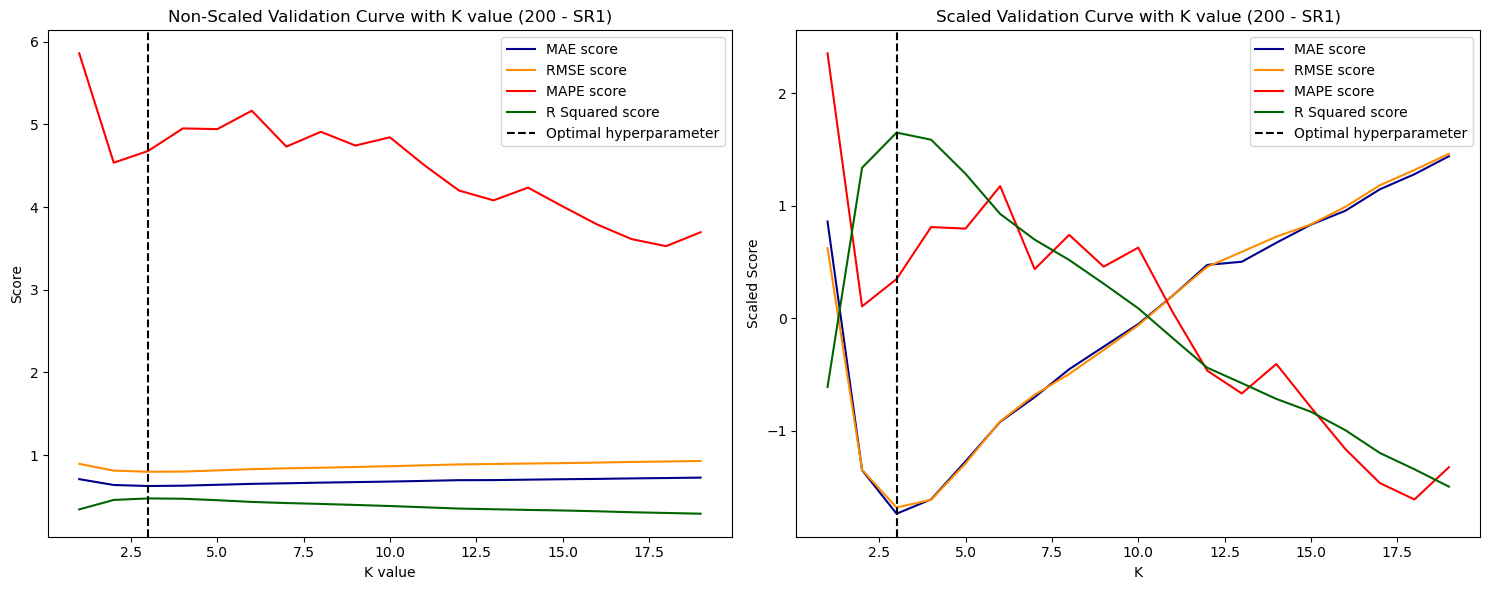

In [6]:
k = 3
df = pd.DataFrame(cv_score_list_200_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (200 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (200 - SR1)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [7]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal400.csv')

In [8]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.669349,0.579945,0.567255,0.559913,0.564491,0.573666,0.579383,0.587198,0.596695,0.602179,0.606922,0.613864,0.624075,0.629048,0.633967,0.637902,0.642761,0.646660,0.649218
Validation Score RMSE,0.844469,0.735430,0.716934,0.713544,0.719878,0.729836,0.736402,0.745949,0.754812,0.759452,0.767680,0.777115,0.789901,0.798098,0.805591,0.811772,0.817775,0.824442,0.829497
Validation Score MAPE,6.088755,5.497259,4.790812,4.723539,4.732173,5.073496,5.286968,5.175257,5.005160,4.809706,4.532265,4.471917,4.613711,4.672783,4.567067,4.555747,4.593781,4.517895,4.382033
Validation Score R Squared,0.415722,0.556866,0.578876,0.582849,0.575410,0.563582,0.555694,0.544100,0.533202,0.527444,0.517150,0.505208,0.488792,0.478128,0.468283,0.460092,0.452077,0.443107,0.436257


The smallest Validation Score MAE is 0.5599132972670563, found in K = 4.
The smallest Validation Score RMSE is 0.7135437054224846, found in K = 4.
The smallest Validation Score MAPE is 4.38203339397284, found in K = 19.
The largest Validation Score R Squared is 0.5828493948035622, found in K = 4.
Validation Computation Time: 0.12 seconds


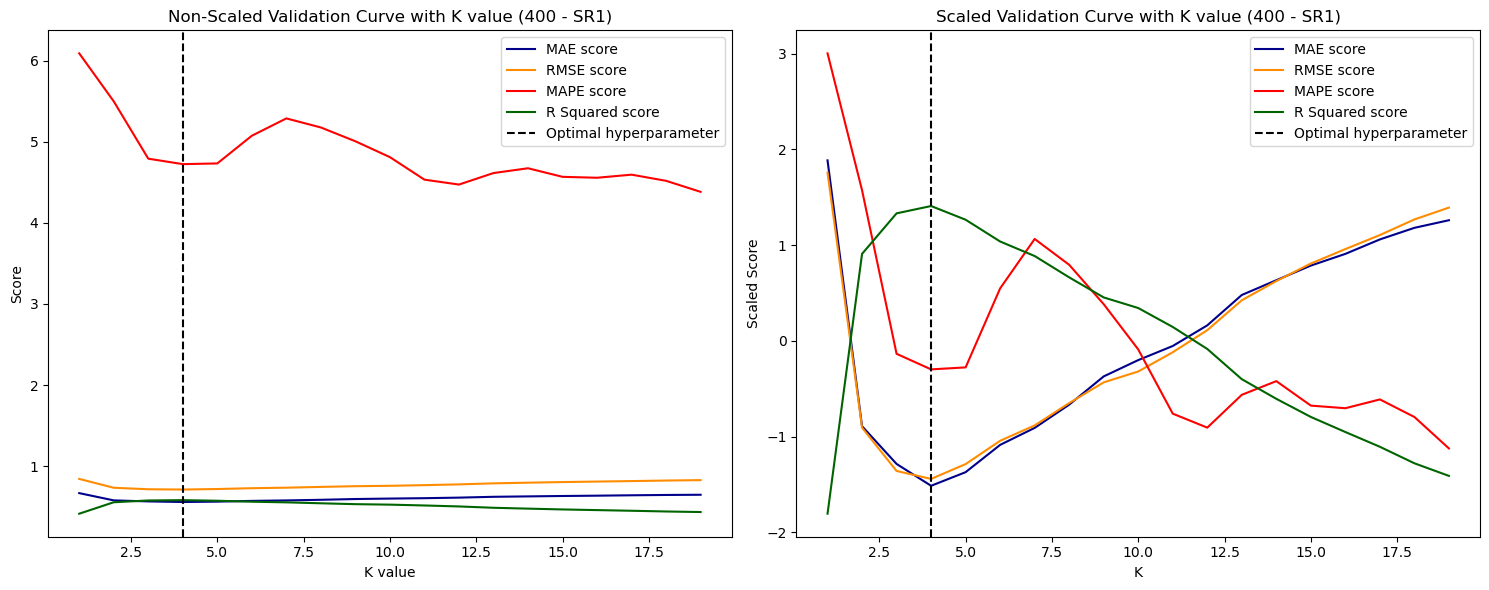

In [9]:
k = 4
df = pd.DataFrame(cv_score_list_400_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (400 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (400 - SR1)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [10]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal600.csv')

In [11]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.636573,0.560207,0.539297,0.526699,0.529164,0.528479,0.531893,0.538942,0.548414,0.553679,0.561764,0.568872,0.573592,0.581000,0.585393,0.591011,0.597448,0.605499,0.609528
Validation Score RMSE,0.808875,0.710302,0.680447,0.664133,0.669710,0.672096,0.678371,0.686587,0.696904,0.703201,0.713671,0.721826,0.728898,0.736514,0.742773,0.748782,0.756959,0.765520,0.770920
Validation Score MAPE,5.906242,5.248057,4.498007,4.424712,4.395275,4.274500,4.523103,4.814998,4.784236,4.652446,4.719278,4.579107,4.524217,4.301636,4.348112,4.250114,4.089288,4.211982,4.231721
Validation Score R Squared,0.463939,0.586632,0.620649,0.638622,0.632527,0.629904,0.622961,0.613773,0.602078,0.594855,0.582701,0.573109,0.564703,0.555559,0.547973,0.540630,0.530542,0.519864,0.513066


The smallest Validation Score MAE is 0.5266989083602176, found in K = 4.
The smallest Validation Score RMSE is 0.6641330184220484, found in K = 4.
The smallest Validation Score MAPE is 4.089288405515567, found in K = 17.
The largest Validation Score R Squared is 0.6386218717446136, found in K = 4.
Validation Computation Time: 0.11 seconds


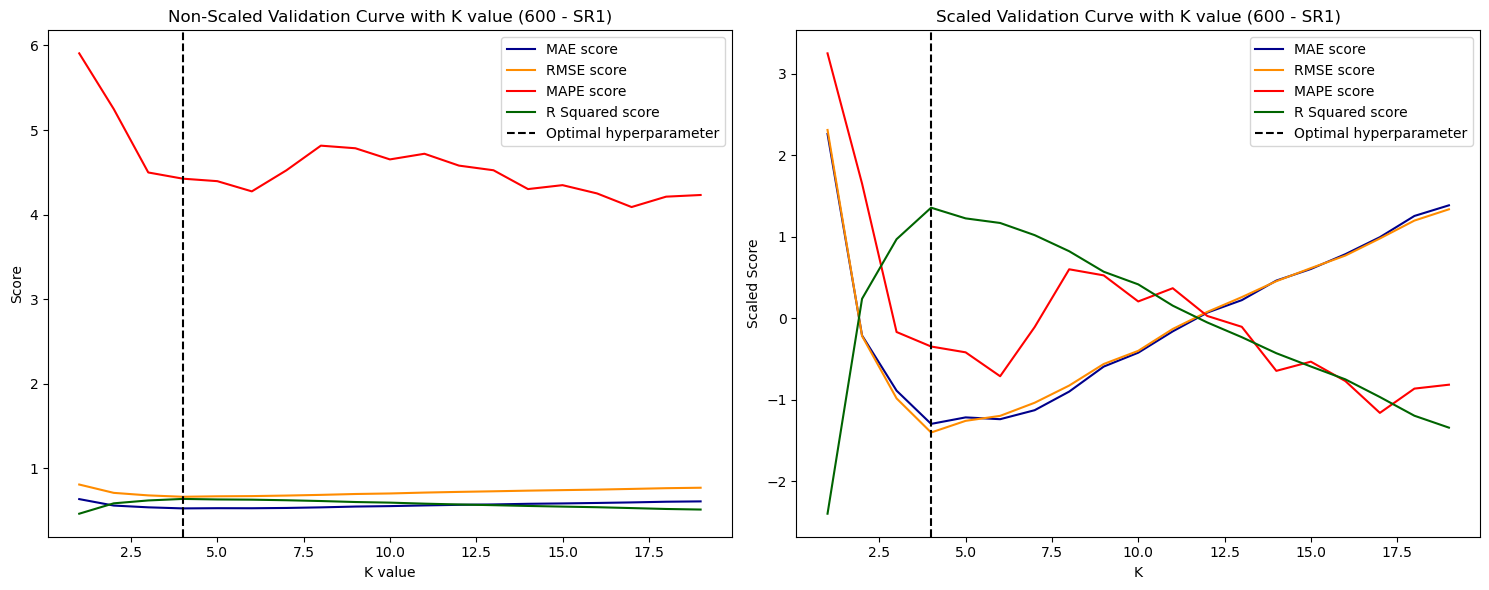

In [12]:
k = 4
df = pd.DataFrame(cv_score_list_600_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (600 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (600 - SR1)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [13]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal800.csv')

In [14]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.631663,0.552834,0.525760,0.510171,0.508703,0.508361,0.512622,0.512821,0.517220,0.521478,0.529098,0.534462,0.541410,0.545843,0.553335,0.558328,0.562082,0.567588,0.573758
Validation Score RMSE,0.801114,0.702583,0.664521,0.643530,0.641057,0.641793,0.647104,0.648817,0.652772,0.657776,0.667172,0.677255,0.684352,0.690267,0.698578,0.705601,0.710883,0.717173,0.724188
Validation Score MAPE,6.068220,5.266616,4.446497,4.120073,4.182045,4.192895,4.502097,4.336505,4.489300,4.235253,4.150796,4.198972,4.305860,4.342178,4.459683,4.317644,4.166743,4.137468,4.175055
Validation Score R Squared,0.474176,0.595566,0.638200,0.660696,0.663298,0.662525,0.656917,0.655098,0.650880,0.645507,0.635307,0.624201,0.616283,0.609622,0.600164,0.592085,0.585954,0.578595,0.570311


The smallest Validation Score MAE is 0.5083611654501607, found in K = 6.
The smallest Validation Score RMSE is 0.6410570939991089, found in K = 5.
The smallest Validation Score MAPE is 4.120072658264655, found in K = 4.
The largest Validation Score R Squared is 0.6632984308888135, found in K = 5.
Validation Computation Time: 0.13 seconds


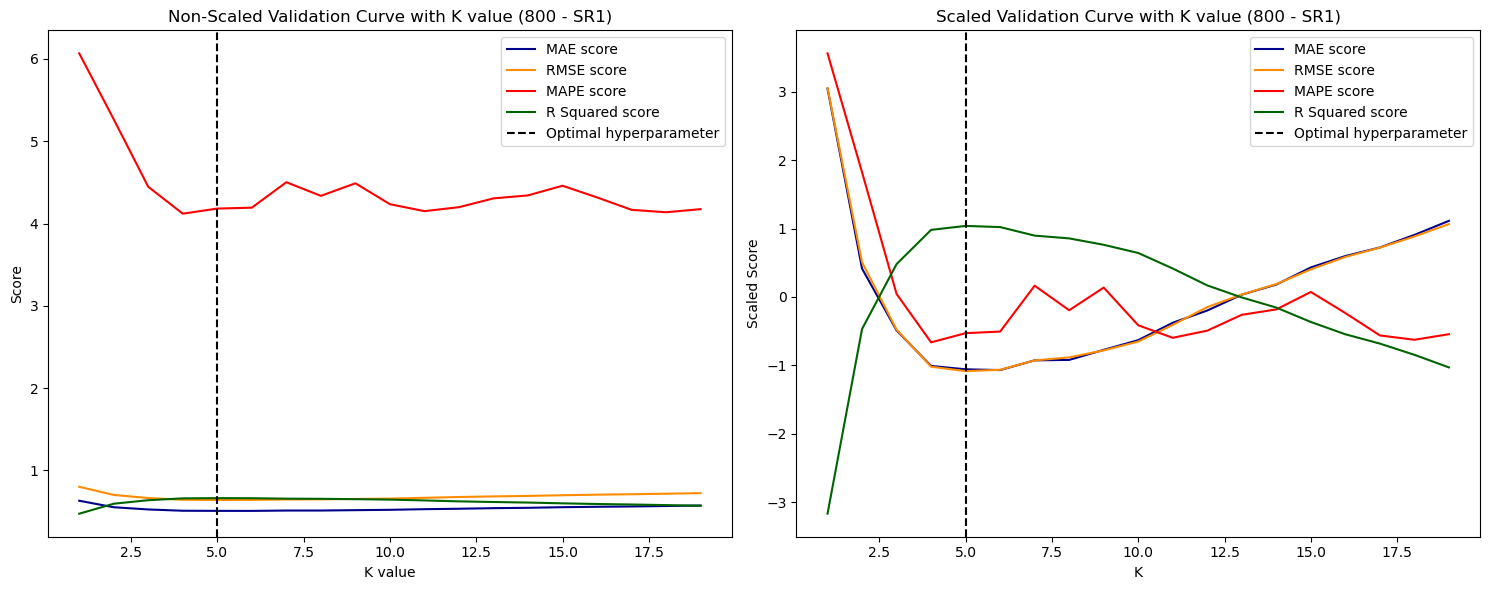

In [15]:
k = 5
df = pd.DataFrame(cv_score_list_800_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (800 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (800 - SR1)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [16]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1000.csv')

In [17]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.618664,0.528926,0.509447,0.493524,0.487431,0.482426,0.489429,0.492282,0.494237,0.500195,0.501943,0.509000,0.513441,0.518920,0.521147,0.527182,0.534634,0.539559,0.544744
Validation Score RMSE,0.785154,0.675082,0.640983,0.620558,0.610743,0.606970,0.614712,0.619482,0.623840,0.631856,0.633493,0.643106,0.649445,0.655541,0.659594,0.667516,0.674711,0.680263,0.686877
Validation Score MAPE,4.932105,4.050787,4.078304,3.830551,3.648227,3.607339,3.754379,3.813200,4.044316,3.944902,3.764166,3.984249,3.819682,3.725263,3.680972,3.792729,4.035007,4.052662,4.155967
Validation Score R Squared,0.494918,0.626608,0.663376,0.684488,0.694389,0.698153,0.690404,0.685581,0.681142,0.672894,0.671197,0.661143,0.654430,0.647912,0.643545,0.634931,0.627019,0.620855,0.613447


The smallest Validation Score MAE is 0.4824262212312285, found in K = 6.
The smallest Validation Score RMSE is 0.60697043403567, found in K = 6.
The smallest Validation Score MAPE is 3.607339038291391, found in K = 6.
The largest Validation Score R Squared is 0.6981530492951926, found in K = 6.
Validation Computation Time: 0.13 seconds


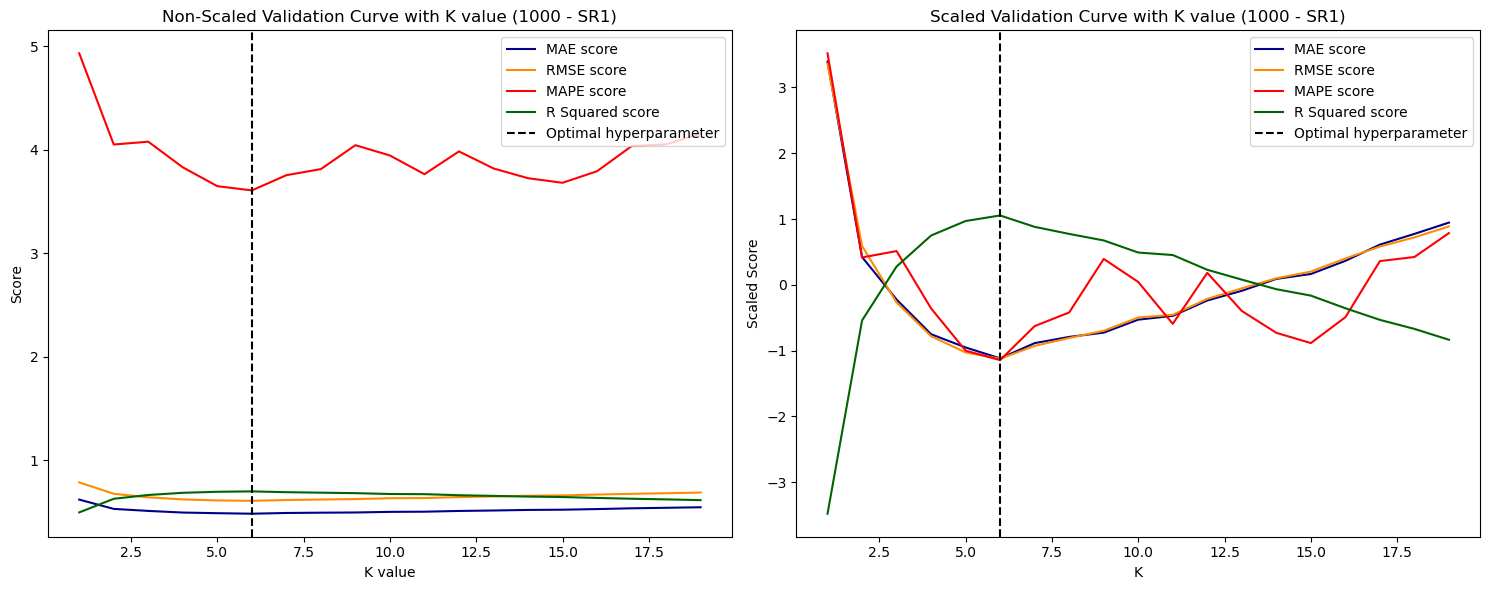

In [18]:
k = 6
df = pd.DataFrame(cv_score_list_1000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1000 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1000 - SR1)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [19]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1500.csv')

In [20]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1500_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.618025,0.524477,0.498660,0.484121,0.476554,0.468497,0.468904,0.468991,0.471405,0.473695,0.474959,0.478992,0.480370,0.482344,0.486009,0.491241,0.494793,0.498398,0.501157
Validation Score RMSE,0.776725,0.658409,0.629256,0.611897,0.600842,0.593520,0.593247,0.591948,0.593288,0.596419,0.598662,0.602585,0.605170,0.609946,0.614012,0.620861,0.625358,0.629590,0.632904
Validation Score MAPE,5.233463,3.976548,4.230732,4.300671,3.813363,3.849123,3.633947,3.591909,3.497756,3.577480,3.619319,3.331458,3.603662,3.537876,3.345497,3.437406,3.296957,3.385724,3.390605
Validation Score R Squared,0.505704,0.644824,0.675581,0.693233,0.704217,0.711383,0.711648,0.712910,0.711609,0.708557,0.706360,0.702499,0.699942,0.695187,0.691108,0.684179,0.679588,0.675236,0.671809


The smallest Validation Score MAE is 0.46849682498506817, found in K = 6.
The smallest Validation Score RMSE is 0.591947748167549, found in K = 8.
The smallest Validation Score MAPE is 3.296956555968283, found in K = 17.
The largest Validation Score R Squared is 0.7129097358268401, found in K = 8.
Validation Computation Time: 0.14 seconds


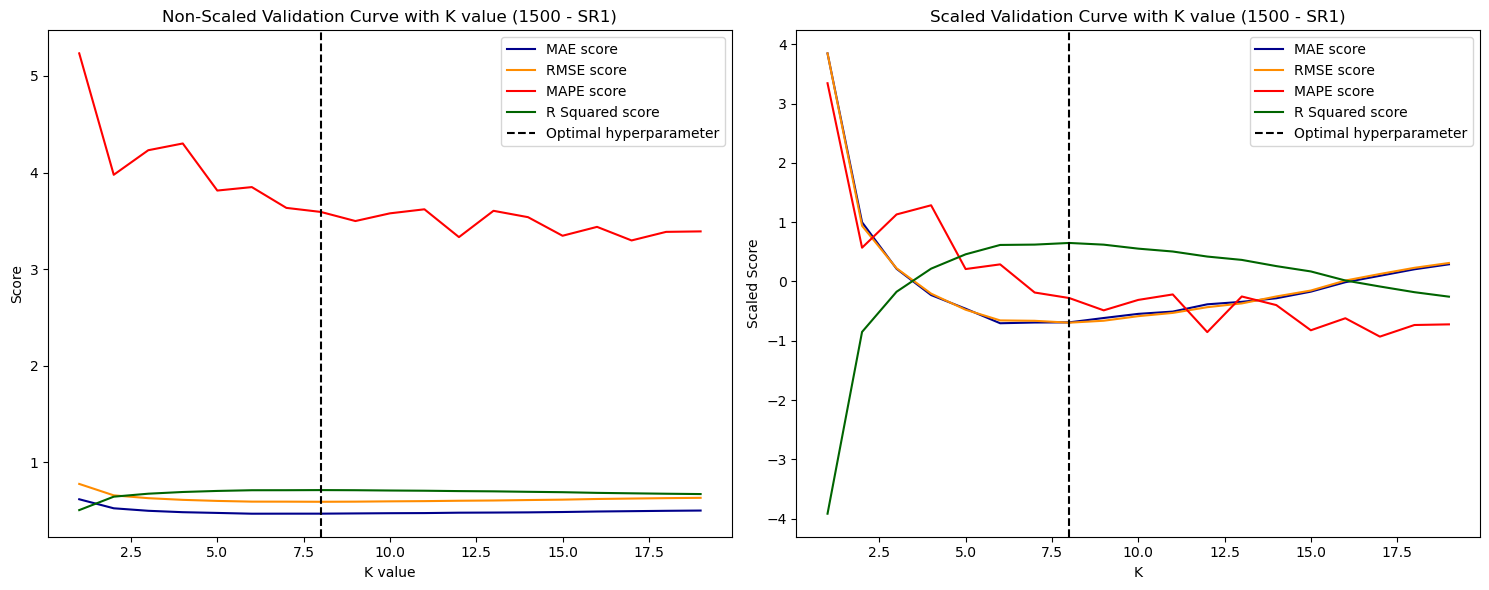

In [21]:
k = 8
df = pd.DataFrame(cv_score_list_1500_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1500 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1500 - SR1)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [22]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal2000.csv')

In [23]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_k = {}
neighbors_range = np.arange(1, 20)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_2000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Validation Score MAE,0.596315,0.505061,0.477793,0.465136,0.457328,0.456550,0.452176,0.449759,0.447147,0.450069,0.452440,0.453979,0.456851,0.457934,0.461246,0.463578,0.466419,0.469562,0.472460
Validation Score RMSE,0.745921,0.635622,0.607632,0.589097,0.576667,0.576371,0.572228,0.569164,0.566354,0.568166,0.570806,0.572682,0.576132,0.578581,0.582272,0.584718,0.589182,0.592386,0.596735
Validation Score MAPE,4.602336,3.453631,2.827800,2.871323,2.838791,3.052770,3.304967,3.088695,2.840667,2.871052,3.035006,3.064544,3.195476,3.165938,3.232162,3.141885,3.368156,3.371603,3.318653
Validation Score R Squared,0.544134,0.668983,0.697494,0.715668,0.727540,0.727820,0.731719,0.734585,0.737199,0.735514,0.733051,0.731293,0.728046,0.725729,0.722218,0.719879,0.715586,0.712485,0.708248


The smallest Validation Score MAE is 0.4471470524659286, found in K = 9.
The smallest Validation Score RMSE is 0.5663538320586418, found in K = 9.
The smallest Validation Score MAPE is 2.827800390445612, found in K = 3.
The largest Validation Score R Squared is 0.7371987624134827, found in K = 9.
Validation Computation Time: 0.14 seconds


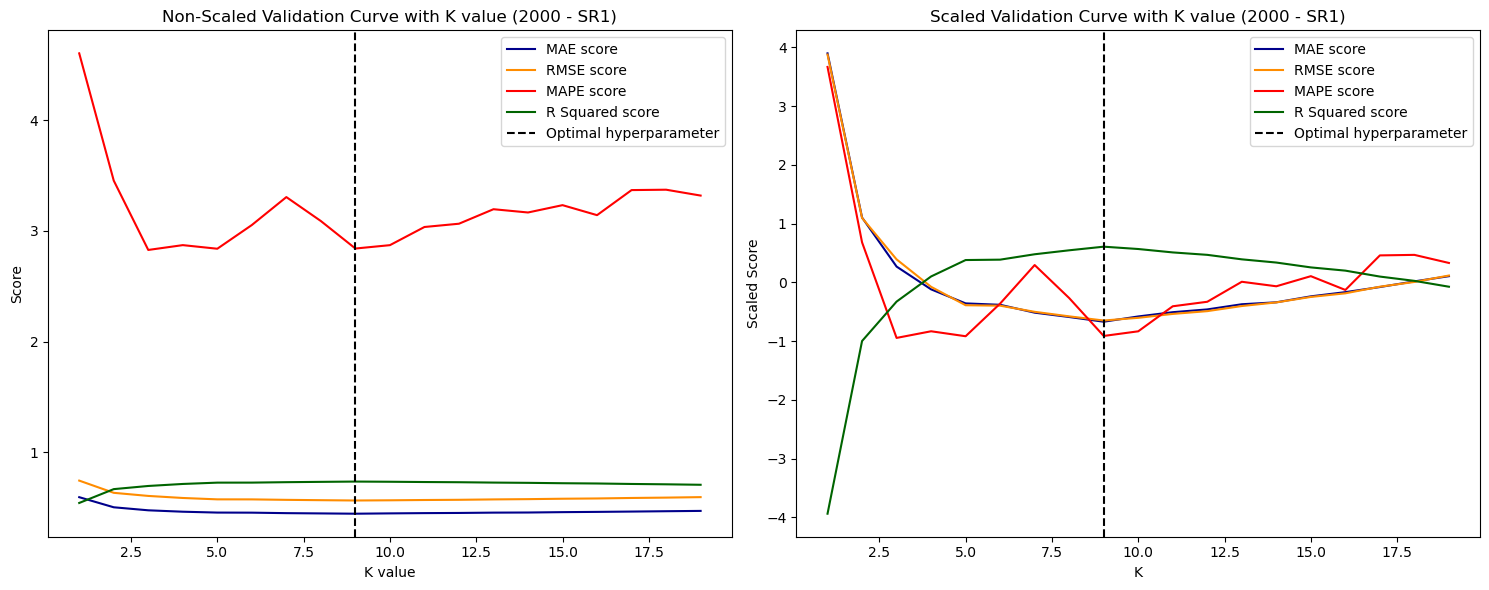

In [24]:
k = 9
df = pd.DataFrame(cv_score_list_2000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (2000 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (2000 - SR1)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [25]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_k = [cv_score_list_200_k, cv_score_list_400_k, cv_score_list_600_k, cv_score_list_800_k,cv_score_list_1000_k,
                     cv_score_list_1500_k, cv_score_list_2000_k]

# Calculate means
all_means_k = calculate_means(data_structures_k)

In [26]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_k = replace_keys(all_means_k, new_keys)

In [27]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_k_df = pd.DataFrame(all_means_k).T
all_means_k_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.682368,0.868908,4.473896,0.380005
400,0.608657,0.772557,4.846859,0.509623
600,0.566708,0.718763,4.567212,0.575478
800,0.540397,0.682976,4.425995,0.616599
1000,0.516165,0.651575,3.932358,0.650865
1500,0.491663,0.620244,3.718605,0.683451
2000,0.469042,0.592143,3.191866,0.711431


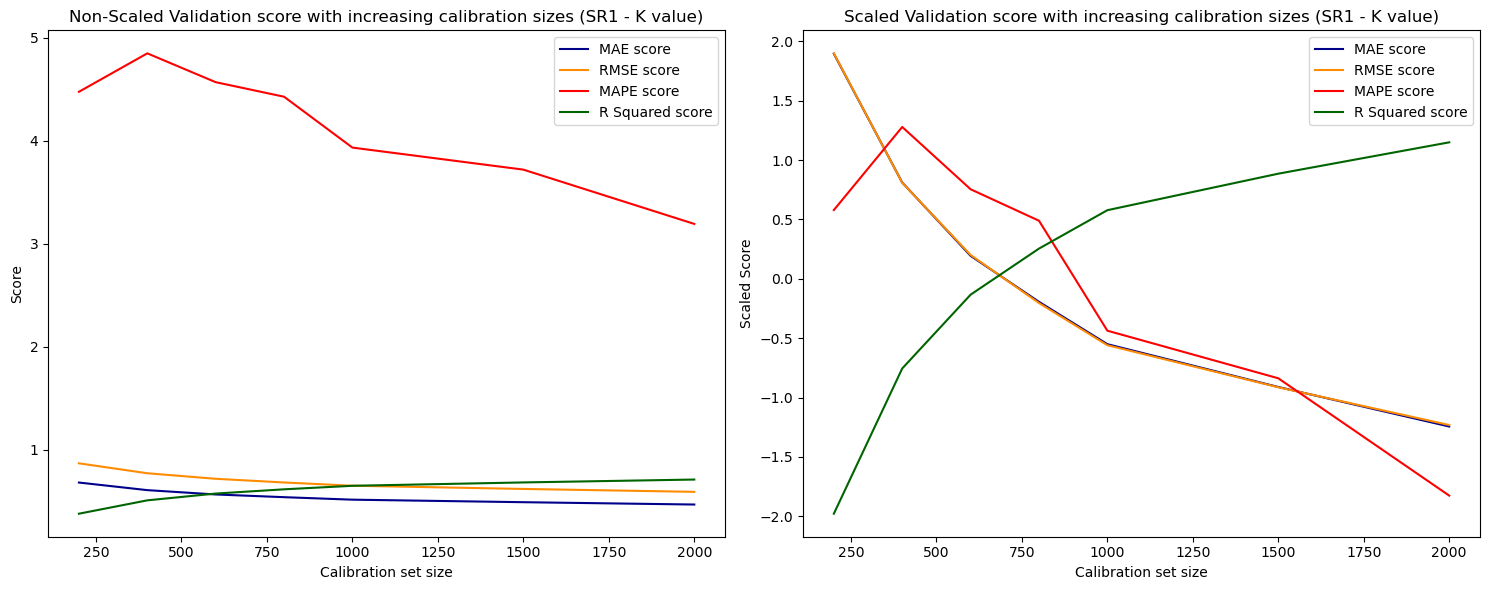

In [28]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_k_df), columns=all_means_k_df.columns, index=all_means_k_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_k_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR1 - K value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR1 - K value)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [29]:
filenames = ['SR1_input_randomfield_cal200','SR1_input_randomfield_cal400', 'SR1_input_randomfield_cal600',
             'SR1_input_randomfield_cal800', 'SR1_input_randomfield_cal1000', 'SR1_input_randomfield_cal1500', 'SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/SR1/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-1.774013
1,47,42,-0.393699
2,92,88,-0.462323
3,24,43,0.601361
4,37,92,-0.129720
...,...,...,...
3995,93,12,-3.037629
3996,56,25,0.688154
3997,22,8,-0.676579
3998,38,35,-0.744753


In [30]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

nn_model = KNeighborsRegressor(n_neighbors=9)
nn_model.fit(eval_combined_array_coordinates,combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = nn_model.predict(eval_combined_array_test)
    
rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.4361870402194696
RMSE: 0.5464762985074223
MAPE: 2.0035452412137733
R Squared: 0.7622247478011608
Testing Computation Time: 0.11 seconds


### Plotting Spatial Interpolation of entire area with Model

In [31]:
filenames = ['cal_SR1_input_randomfield_cal200', 'cal_SR1_input_randomfield_cal400', 'cal_SR1_input_randomfield_cal600', 'cal_SR1_input_randomfield_cal800', 'cal_SR1_input_randomfield_cal1000', 'cal_SR1_input_randomfield_cal1500', 'cal_SR1_input_randomfield_cal2000',
            'val_SR1_input_randomfield_cal2000', 'test_SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/SR1/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-1.154367
1,40,74,-0.398708
2,90,28,-0.161047
3,51,84,-1.042425
4,32,48,-1.328360
...,...,...,...
5995,93,12,-3.037629
5996,56,25,0.688154
5997,22,8,-0.676579
5998,38,35,-0.744753


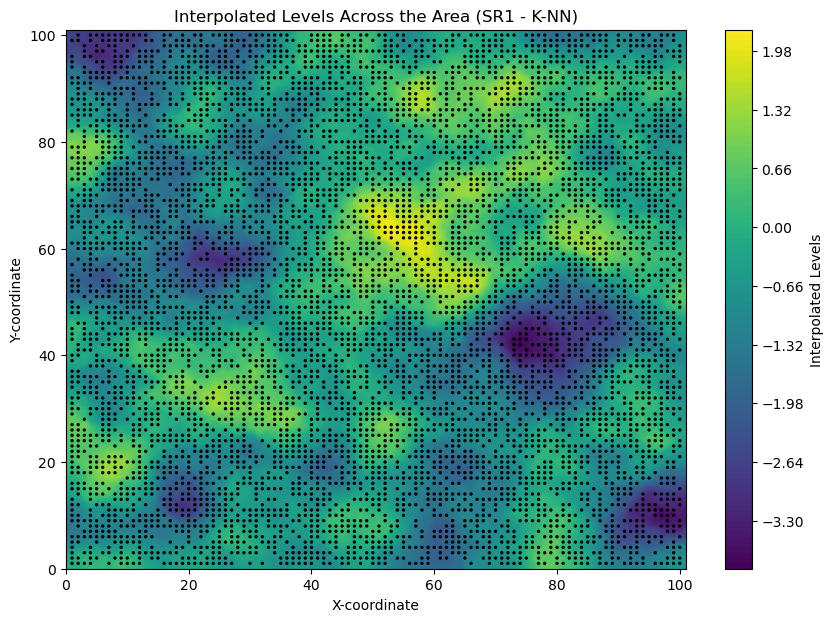

Spatial Interpolation Computation Time: 0.02 seconds


In [35]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
nn_model = KNeighborsRegressor(n_neighbors=9)
nn_model.fit(observed_locations,observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = nn_model.predict(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (SR1 - K-NN)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")